# K Nearest Neighbors (KNN) – Diabetes Data

## Project Description:
This project builds a k-Nearest Neighbors (kNN) classifier to predict diabetes (binary Outcome) from routine clinical measures in the Pima-style dataset (e.g., Glucose, BloodPressure, BMI, etc.). After basic EDA and data cleaning (removing/handling implausible zeros), we scale features, tune the neighborhood size k via cross-validation, and evaluate generalization on held-out data. Because the dataset is imbalanced, we compare accuracy with class-aware metrics and explore simple rebalancing.

### Objectives:
* Data preparation: identify and address impossible zeros and outliers; standardize features for distance-based learning.
* Model development: Train kNN over a grid of k values and distance settings; use 5-fold CV to select k that maximizes validation performance.
* Model selection & reporting:Plot accuracy vs k; choose the smallest, best k; report confusion matrix and ROC-AUC on the test split.
* Interpretation & limits: Discuss how neighborhood size, distance metric, and feature scaling influence decision boundaries; note kNN’s sensitivity to noisy/irrelevant features.


### Public dataset source:
[Kaggle Cancer Data Data Set](https://www.kaggle.com/datasets/abdallamahgoub/diabetes?resource=download)
This dataset originates from the Pima Indians Diabetes dataset, which contains contains the characteristics of patients diagnosed with diabetes. Collected data include:
*Pregnancies — count (integer)
*Glucose — 2-hour plasma glucose (mg/dL)
*BloodPressure — diastolic BP (mmHg)
*SkinThickness — triceps skinfold thickness (mm)
*Insulin — 2-hour serum insulin (µU/mL)
*BMI — kg/m²
*Pedigree — diabetes pedigree function (unitless index of family history)
*Age — years
*Outcome — 0/1 (no diabetes / diabetes)

In [58]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.impute import SimpleImputer

## EDA

In [2]:
# Establish file path and import data
path = 'diabetes_data.csv'
df = pd.read_csv(path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


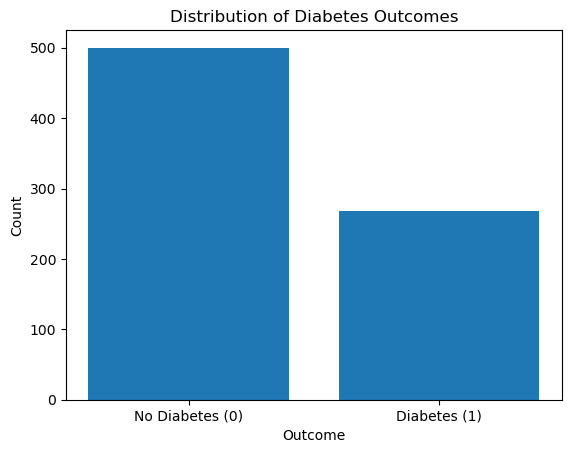

In [24]:
counts = df['Outcome'].value_counts().sort_index()   # index = [0, 1]
labels = ['No Diabetes (0)', 'Diabetes (1)']

plt.bar(labels, counts.values)
plt.title("Distribution of Diabetes Outcomes")
plt.ylabel('Count')
plt.xlabel('Outcome')
plt.show()

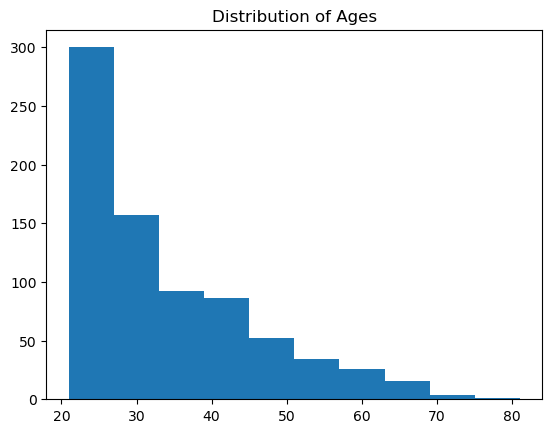

In [ ]:
plt.hist(df['Age'])
plt.title("Distribution of Ages")
plt.show()

There is a large discrepancy in count of diagnoses with diabetes vs no diabetes. This imbalance in the classes may influence model performance

In [26]:
g_counts = df['Glucose'].value_counts().sort_index()
bp_counts = df['BloodPressure'].value_counts().sort_index()
st_counts = df['SkinThickness'].value_counts().sort_index()
in_counts = df['Insulin'].value_counts().sort_index()
bmi_counts = df['BMI'].value_counts().sort_index()

In [27]:
counts_zeros = [g_counts[0], bp_counts[0], st_counts[0], in_counts[0], bmi_counts[0]]
print(counts_zeros)

[5, 35, 227, 374, 11]


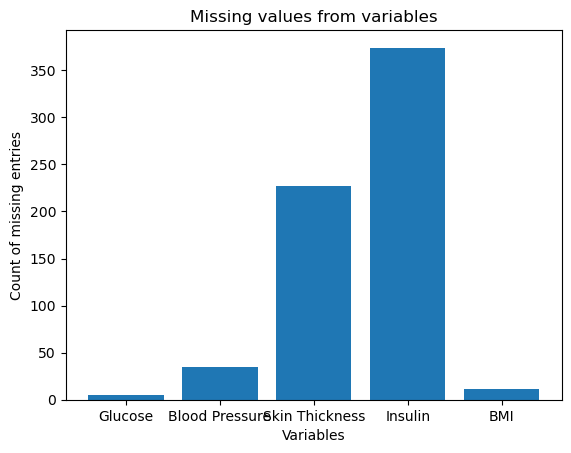

In [28]:
labels = ['Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI']

plt.bar(labels, counts_zeros)
plt.title('Missing values from variables')
plt.xlabel('Variables')
plt.ylabel('Count of missing entries')
plt.show()

In [3]:
# Remove zeroes from glucose, BP, and BMI
cols = ["Glucose", "BloodPressure", "BMI"]
df_clean = df[(df[cols] != 0).all(axis=1)]

/var/folders/cx/jsmdsr392b16bs81k3s1s4n00000gn/T/ipykernel_1161/1947428655.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])


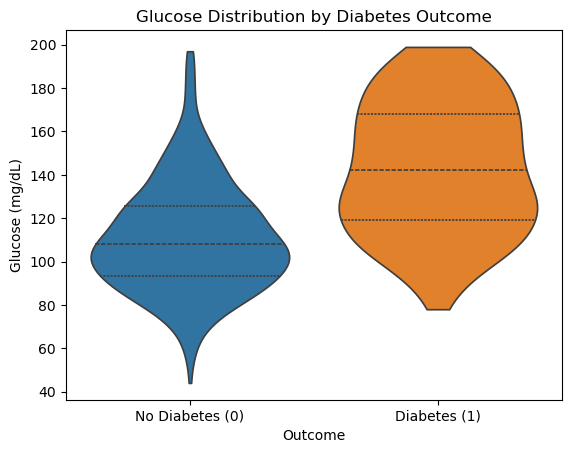

In [22]:
ax = sns.violinplot(
    data=df_clean,
    x='Outcome',
    y='Glucose',
    hue = 'Outcome',
    legend = False,
    order=[0, 1],
    inner='quartile',   # show median & IQR
    cut=0               # trim to data range
)
ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])
ax.set_title('Glucose Distribution by Diabetes Outcome')
ax.set_xlabel('Outcome')
ax.set_ylabel('Glucose (mg/dL)')
plt.show()

/var/folders/cx/jsmdsr392b16bs81k3s1s4n00000gn/T/ipykernel_19949/2393589770.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])


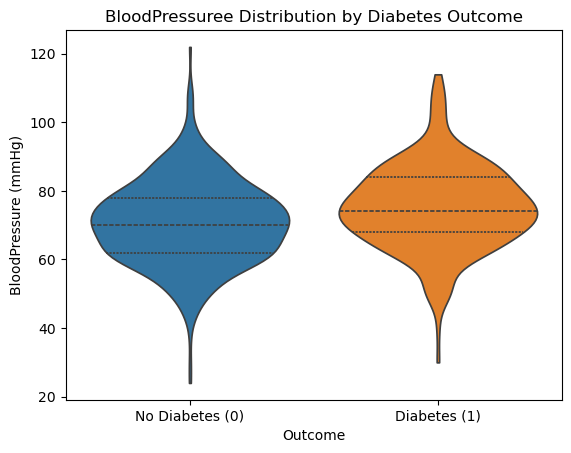

In [41]:
ax = sns.violinplot(
    data=df_clean,
    x='Outcome',
    y='BloodPressure',
    hue = 'Outcome',
    order=[0, 1],
    legend = False,
    inner='quartile',   # show median & IQR
    cut=0               # trim to data range
)
ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])
ax.set_title('BloodPressuree Distribution by Diabetes Outcome')
ax.set_xlabel('Outcome')
ax.set_ylabel('BloodPressure (mmHg)')
plt.show()

/var/folders/cx/jsmdsr392b16bs81k3s1s4n00000gn/T/ipykernel_19949/1546679466.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])


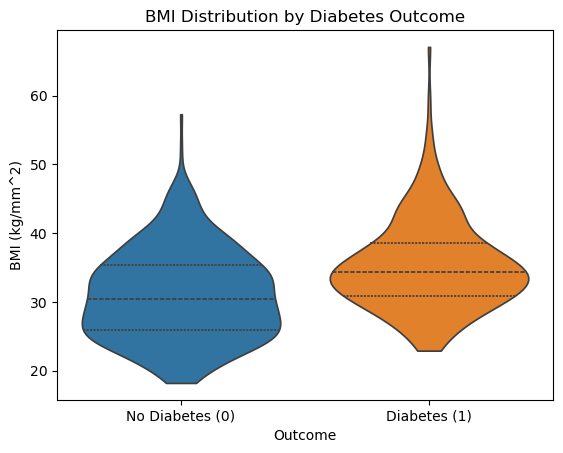

In [40]:
ax = sns.violinplot(
    data=df_clean,
    x='Outcome',
    y='BMI',
    hue = 'Outcome',
    order=[0, 1],
    legend = False,
    inner='quartile',   # show median & IQR
    cut=0               # trim to data range
)
ax.set_xticklabels(['No Diabetes (0)', 'Diabetes (1)'])
ax.set_title('BMI Distribution by Diabetes Outcome')
ax.set_xlabel('Outcome')
ax.set_ylabel('BMI (kg/mm^2)')
plt.show()

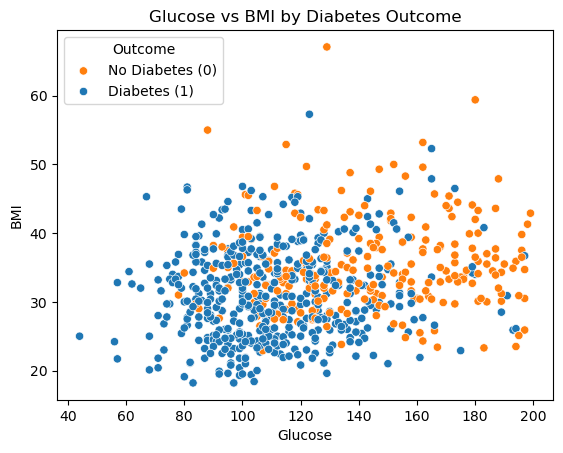

In [45]:
sns.scatterplot(
    data=df_clean,
    x='Glucose',
    y='BMI',
    hue='Outcome',
    hue_order = [0,1]
    
)
plt.title('Glucose vs BMI by Diabetes Outcome')
plt.legend(title='Outcome', labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.show()

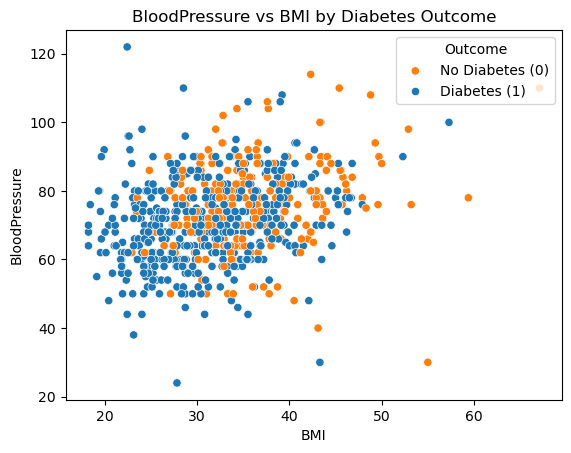

In [49]:
sns.scatterplot(
    data=df_clean,
    x='BMI',
    y='BloodPressure',
    hue='Outcome',
    hue_order = [0,1]
)
plt.title('BloodPressure vs BMI by Diabetes Outcome')
plt.legend(title='Outcome', labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.show()

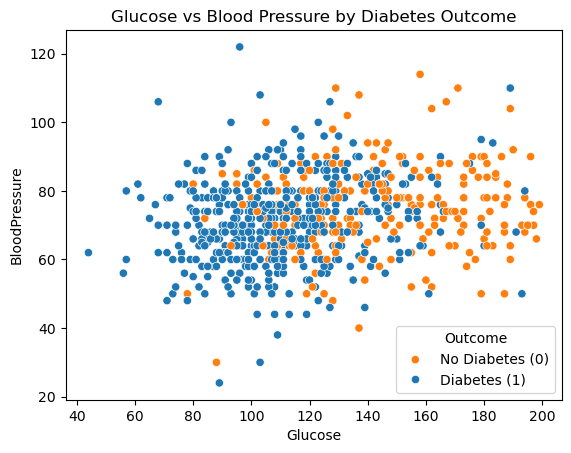

In [50]:
sns.scatterplot(
    data=df_clean,
    x='Glucose',
    y='BloodPressure',
    hue='Outcome',
    hue_order = [0,1]
    
)
plt.title('Glucose vs Blood Pressure by Diabetes Outcome')
plt.legend(title='Outcome', labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.show()

## Normalizing & Splitting Data

In [4]:
# Split the data into features (X) and target (y)
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features using StandardScaler after splitting to prevent data leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Fitting & Evaluating the Model

In [5]:
# Train the model with different values of k, aka neighbors
# Pass botht the features and the target variables
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [6]:
# Make a prediction on the test dataset
y_pred = knn.predict(X_test)

In [9]:
# Evaluate the model with accuracy
# Check the prediction against the actual values in the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7172413793103448


## Cross Validation

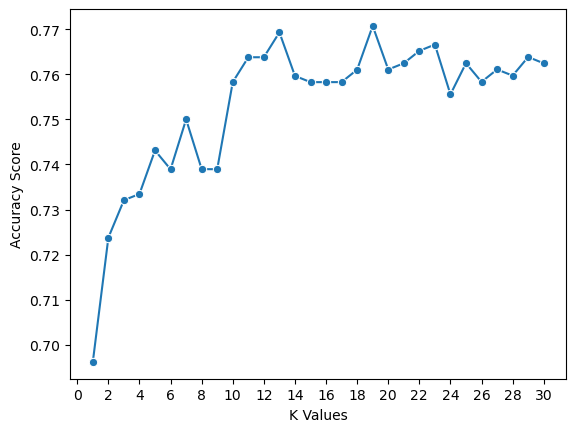

In [19]:
# How to find the best value of k?
# Can try to swap in k=2 or k=4 (perform worse) or can try more systematically through CV
# Try looping through systematically 

k_values = [i for i in range (1,31)] # Try a range of values for k
scores = [] # Empty list to store results

# Using CV, no splitting
# Remember to scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) # Implement an instance of KNN model
    # Number of groups: 5 equal-sized groups and use 4 to train and 1 to test result
    score = cross_val_score(knn, X, y, cv=5) # Find accuracy of each run
    scores.append(np.mean(score)) # Average score to find best model

# Plot results
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.xticks(np.arange(0, 32, 2));

From the graph, we can see that the accuracy of the model increases while k increases until it reaches about 11 and then hovers/plateaus around the same accuracy score of 0.76. This is still pretty unsatisfactory performance, however. Let's try improving the model.

In [37]:
# Balancing the dataset
# keep all positives (Outcome==1)
pos = df_clean[df_clean['Outcome'] == 1]

# sample 50% of negatives randomly (Outcome==0)
neg = df_clean[df_clean['Outcome'] == 0].sample(frac=0.50, random_state=42)

# combine and shuffle
balanced_df = pd.concat([pos, neg], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# quick check
print(balanced_df['Outcome'].value_counts())

Outcome
1    249
0    238
Name: count, dtype: int64


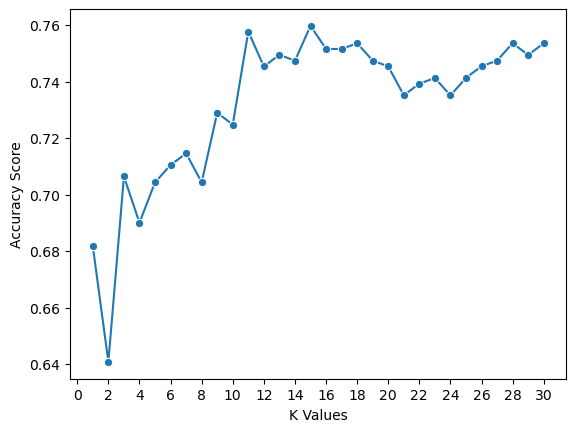

In [38]:
# Re-assign
X = balanced_df.drop('Outcome', axis=1)
y = balanced_df['Outcome']

k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) 
    score = cross_val_score(knn, X, y, cv=5) # Find accuracy of each run
    scores.append(np.mean(score)) # Average score to find best model

# Plot results
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.xticks(np.arange(0, 32, 2));

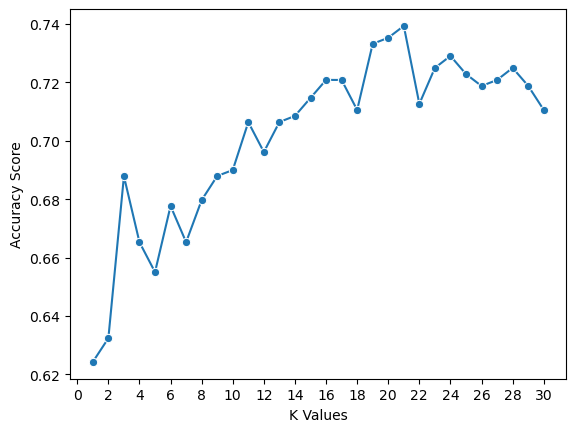

In [ ]:
# Try with only variables of interest
cols = ['Glucose', 'BloodPressure','BMI']
X = balanced_df[cols]

scaler = StandardScaler()
X = scaler.fit_transform(X)
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) 
    score = cross_val_score(knn, X, y, cv=5) # Find accuracy of each run
    scores.append(np.mean(score)) # Average score to find best model

# Plot results
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.xticks(np.arange(0, 32, 2));

The performance did not get much better.

In [43]:
# Try imputing the zero values instead of deleting them
# According to feature and grouped by Outcome

cols = ["Glucose", "BloodPressure", "BMI"]

# treat zeros as missing only in those columns
tmp = df.copy()
tmp[cols] = tmp[cols].replace(0, np.nan)

# fill NaNs with the median *within each Outcome group*
group_medians = tmp.groupby('Outcome')[cols].transform('median')
tmp[cols] = tmp[cols].fillna(group_medians)
df_imputed = tmp

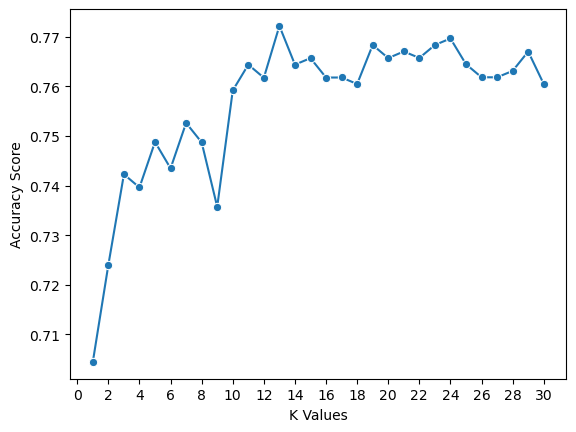

In [46]:
X = df_imputed.drop('Outcome', axis=1)
y = df['Outcome']

scaler = StandardScaler()
X = scaler.fit_transform(X)

k_values = [i for i in range (1,31)]
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) 
    score = cross_val_score(knn, X, y, cv=5) # Find accuracy of each run
    scores.append(np.mean(score)) # Average score to find best model

# Plot results
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.xticks(np.arange(0, 32, 2));

## More Evaluation Metrics

In [ ]:
# Re-train model using the best k
best_index = np.argmax(scores)
best_k = k_values[best_index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [59]:
# Evaluate with accuracy, precision, and recall
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.70
Precision: 0.55
Recall: 0.55
F1: 0.55
ROC AUC: 0.66
